CIFAR10 dataset trained on all classes with resnet56 without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

## Training

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'resnet50',
    "DS_INFO": 'complete',
    "resample": True,
    "neg_class": ['ship'],
    "NUM_EPOCHS": 5,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

cat               : 5000
airplane          : 5000
deer              : 5000
automobile        : 5000
ship              : 5000
horse             : 5000
truck             : 5000
dog               : 5000
bird              : 5000
frog              : 5000

Total number of images: 50000, in 10 classes
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 5 2 3 6 0 3 9 5 3]
[9 4 2 6 1 2 1 8 9 7]
[9 7 8 1 4 6 9 5 5 3]
[5 8 8 8 7 4 3 3 1 9]
[5 1 3 1 5 0 0 3 1 8]
[4 7 3 6 3 1 3 9 8 4]
[1 8 7 3 5 6 3 9 4 3]
[8 5 9 2 7 3 6 0 2 3]
[5 2 2 9 8 7 4 9 2 0]
[3 3 8 4 3 8 4 4 6 9]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


### Resnet50 transfer learning
https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import layers

Create and compile the model

In [5]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=config["IMG_SIZE"])

In [6]:
res_net.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(params["NUM_CLASSES"], activation='softmax')

resnet50_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [7]:
if config["verbosity"] > 0:
    resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

resnet50_model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(
                log_dir='./logs/resnet50_model', 
                update_freq='batch')]

Train the model

In [9]:
history = resnet50_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/5
546/546 [==============================] - 14s 26ms/step - loss: 11.4071 - accuracy: 0.1010 - val_loss: 10.2066 - val_accuracy: 0.1008
Epoch 2/5
546/546 [==============================] - 10s 18ms/step - loss: 10.0640 - accuracy: 0.1011 - val_loss: 9.9432 - val_accuracy: 0.1010
Epoch 3/5
546/546 [==============================] - 10s 18ms/step - loss: 9.9998 - accuracy: 0.1010 - val_loss: 9.9434 - val_accuracy: 0.1008
Epoch 4/5
546/546 [==============================] - 10s 18ms/step - loss: 9.9885 - accuracy: 0.1012 - val_loss: 9.9380 - val_accuracy: 0.1008
Epoch 5/5
546/546 [==============================] - 10s 18ms/step - loss: 10.0169 - accuracy: 0.1012 - val_loss: 10.0918 - val_accuracy: 0.1007


`Keras`
Save/load the model

In [10]:
# resnet50_model.save('models/{}.h5'.format(model_name))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [11]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

117/117 - 2s - loss: 10.1123 - accuracy: 0.1022


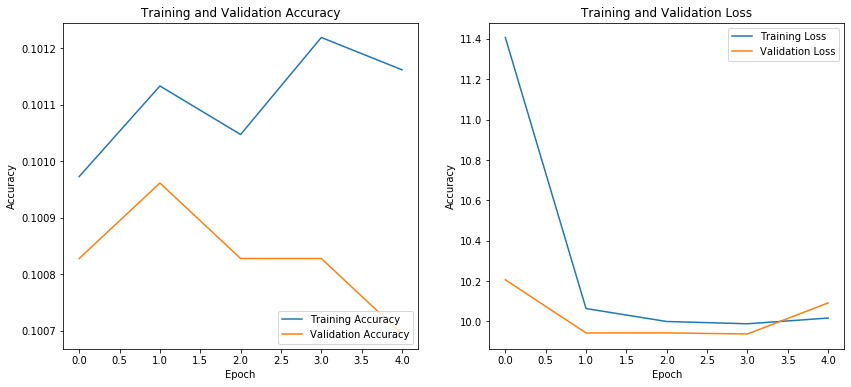

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [13]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.1262 cat
0.1296 airplane
0.0476 deer
0.0940 automobile
0.0958 ship
0.0721 horse
0.1026 truck
0.1200 dog
0.1025 bird
0.1096 frog

Label: truck
Predicton: airplane


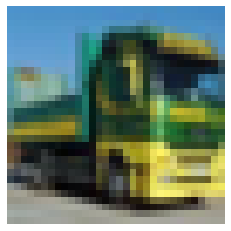

In [14]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [15]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  ship        airplane    Wrong
  1  ship        airplane    Wrong
  2  dog         airplane    Wrong
  3  automobile  airplane    Wrong
  4  dog         airplane    Wrong
  5  airplane    airplane  
  6  automobile  airplane    Wrong
  7  dog         airplane    Wrong
  8  cat         airplane    Wrong
  9  horse       airplane    Wrong
 10  deer        airplane    Wrong
 11  horse       airplane    Wrong
 12  deer        airplane    Wrong
 13  truck       airplane    Wrong
 14  truck       airplane    Wrong
 15  automobile  airplane    Wrong
 16  ship        airplane    Wrong
 17  truck       airplane    Wrong
 18  airplane    airplane  
 19  horse       airplane    Wrong
 20  deer        airplane    Wrong
 21  automobile  airplane    Wrong
 22  truck       airplane    Wrong
 23  truck       airplane    Wrong
 24  ship        airplane    Wrong
 25  truck       airplane    Wrong
 26  ship        airplane    Wrong
 27  bird        air